# Challenges of Evaluating LLM-based Applications
```{epigraph}
Evals are surprisingly often all you need.

-- Greg Brockman, OpenAI's President
```
```{contents}
```
## Non-Deterministic Machines

One of the most fundamental challenges when building products with Large Language Models (LLMs) is their non-deterministic nature. Unlike traditional software systems where the same input reliably produces the same output, LLMs can generate different responses each time they're queried - even with identical prompts and input data. This characteristic is both a strength and a significant engineering challenge.

When you ask ChatGPT or any other LLM the same question multiple times, you'll likely get different responses. This isn't a bug - it's a fundamental feature of how these models work. The "temperature" parameter, which controls the randomness of outputs, allows models to be creative and generate diverse responses. However, this same feature makes it incredibly difficult to build reliable, testable systems.

Consider a financial services company using LLMs to generate investment advice. The non-deterministic nature of these models means that:
- The same market data could yield different analysis conclusions
- Testing becomes exceedingly more complex compared to traditional software
- Regulatory compliance becomes challenging to guarantee
- User trust may be affected by inconsistent responses

### Temperature and Sampling

The primary source of non-determinism in LLMs comes from their sampling strategies. During text generation, the model:
1. Calculates probability distributions for each next token
2. Samples from these distributions based on temperature settings
3. Uses techniques like nucleus sampling to balance creativity and coherence

### The Temperature Spectrum

- Temperature = 0: Most deterministic, but potentially repetitive
- Temperature = 1: Balanced creativity and coherence
- Temperature > 1: Increased randomness, potentially incoherent

In [1]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

from openai import OpenAI
import pandas as pd
from typing import List

def generate_responses(
    model_name: str,
    prompt: str,
    temperatures: List[float],
    attempts: int = 3
) -> pd.DataFrame:
    """
    Generate multiple responses at different temperature settings
    to demonstrate non-deterministic behavior.
    """
    client = OpenAI()
    results = []
    
    for temp in temperatures:
        for attempt in range(attempts):
            response = client.chat.completions.create(
                model=model_name,
                messages=[{"role": "user", "content": prompt}],
                temperature=temp,
                max_tokens=50
            )
            
            results.append({
                'temperature': temp,
                'attempt': attempt + 1,
                'response': response.choices[0].message.content
            })

    # Display results grouped by temperature
    df_results = pd.DataFrame(results)
    for temp in temperatures:
        print(f"\nTemperature = {temp}")
        print("-" * 40)
        temp_responses = df_results[df_results['temperature'] == temp]
        for _, row in temp_responses.iterrows():
            print(f"Attempt {row['attempt']}: {row['response']}")
    
    return df_results

In [3]:
MAX_LENGTH = 10000 # We limit the input length to avoid token issues
with open('../data/apple.txt', 'r') as file:
    sec_filing = file.read()
sec_filing = sec_filing[:MAX_LENGTH] 
df_results = generate_responses(model_name="gpt-3.5-turbo", 
                                prompt=f"Write a single-statement executive summary of the following text: {sec_filing}", 
                                temperatures=[0.0, 1.0, 2.0])


Temperature = 0.0
----------------------------------------
Attempt 1: Apple Inc. filed its Form 10-K for the fiscal year ended September 28, 2024 with the SEC, detailing its business operations and financial performance.
Attempt 2: Apple Inc. filed its Form 10-K with the SEC for the fiscal year ended September 28, 2024, detailing its business operations, products, and financial information.
Attempt 3: Apple Inc. filed its Form 10-K with the SEC for the fiscal year ended September 28, 2024, detailing its business operations, products, and financial information.

Temperature = 1.0
----------------------------------------
Attempt 1: Apple Inc., a well-known seasoned issuer based in California, designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories, with a focus on innovation and technology.
Attempt 2: Apple Inc. filed its Form 10-K with the SEC for the fiscal year ended September 28, 2024, reporting on its business operations, products, an

This simple experiment reveals a fundamental challenge in LLM evaluation: even a simple parameter like temperature can dramatically alter model behavior in ways that are difficult to systematically assess. At temperature 0.0, responses are consistent but potentially too rigid. At 1.0, outputs become more varied but less predictable. At 2.0, responses can be wildly different and often incoherent. This non-deterministic behavior makes traditional software testing approaches inadequate.

The implications for evaluation are profound. How can one effectively test an LLM-powered system when the same prompt can yield radically different outputs based on a single parameter? Traditional testing relies on predictable inputs and outputs, but LLMs force us to grapple with probabilistic behavior. While lower temperatures may seem safer for critical applications, they don't eliminate the underlying uncertainty - they merely mask it. This highlights the need for new evaluation paradigms that can handle both deterministic and probabilistic aspects of LLM behavior.



## Emerging Properties

Beyond their non-deterministic nature, LLMs present another fascinating challenge: emergent abilities that spontaneously arise as models scale up in size. These abilities - from basic question answering to complex reasoning - aren't explicitly programmed but rather emerge "naturally" as the models grow larger and are trained on more data. This makes evaluation fundamentally different from traditional software testing, where capabilities are explicitly coded and can be tested against clear specifications.

```{figure} ../_static/evals/emerging.png
---
name: emerging-properties
alt: Emerging Properties
class: bg-primary mb-1
scale: 60%
align: center
---
Emergent abilities of large language models and the scale {cite}`wei2022emergentabilitieslargelanguage`.
```

 {numref}`emerging-properties` provides a list of emergent abilities of large language models and the scale. The relationship between model scale and emergent abilities follows a fascinating non-linear pattern. Below certain size thresholds, specific abilities may be completely absent from the model - it simply cannot perform certain tasks, no matter how much you try to coax them out. However, once the model reaches critical points in its scaling journey, these abilities can suddenly manifest in what researchers call a phase transition - a dramatic shift from inability to capability. This unpredictable emergence of capabilities stands in stark contrast to traditional software development, where features are deliberately implemented and can be systematically tested.

The implications for evaluation are profound. While conventional software testing relies on stable test suites and well-defined acceptance criteria, LLM evaluation must contend with a constantly shifting landscape of capabilities. What worked to evaluate a 7B parameter model may be completely inadequate for a 70B parameter model that has developed new emergent abilities. This dynamic nature of LLM capabilities forces us to fundamentally rethink our approach to testing and evaluation.

## Problem Statement

Consider a practical example that illustrates these challenges: building a customer support chatbot powered by an LLM. In traditional software development, you would define specific features (like handling refund requests or tracking orders) and write tests to verify each function. But with LLMs, you're not just testing predefined features - you're trying to evaluate emergent capabilities like understanding context, maintaining conversation coherence, and generating appropriate emotional responses.

This fundamental difference raises critical questions about evaluation:
- How do we measure capabilities that weren't explicitly programmed?
- How can we ensure consistent performance when abilities may suddenly emerge or evolve?
- What metrics can capture both the technical accuracy and the subjective quality of responses?

The challenge becomes even more complex when we consider that traditional software evaluation methods simply weren't designed for these kinds of systems. We need new frameworks that can account for both the deterministic aspects we're used to testing and the emergent properties that make LLMs unique. Let's explore how LLM evaluation differs from traditional software testing across several key dimensions:
- **Capability Assessment vs Functional Testing**: Traditional software testing validates specific functionality against predefined requirements. LLM evaluation must assess not necessiraly pre-defined "emergent properties" like reasoning, creativity, and language understanding that extend beyond explicit programming.

- **Metrics and Measurement Challenges**: While traditional software metrics can usually be precisely defined and measured, LLM evaluation often involves subjective qualities like "helpfulness" or "naturalness" that resist straightforward quantification. Even when we try to break these down into numeric scores, the underlying judgment remains inherently human and context-dependent.

- **Dataset Contamination**: Traditional software testing uses carefully crafted test cases with known inputs and expected outputs (e.g., unit tests, integration tests). In contrast, LLMs trained on massive internet-scale datasets risk having already seen and memorized evaluation examples during training, which can lead to artificially inflated performance scores. This requires careful dataset curation to ensure test sets are truly unseen by the model and rigorous cross-validation approaches.

- **Benchmark Evolution**: Traditional software maintains stable test suites over time. LLM benchmarks continuously evolve as capabilities advance, making longitudinal performance comparisons difficult and potentially obsoleting older evaluation methods.

- **Human Evaluation Requirements**: Traditional software testing automates most validation. LLM evaluation may demand significant human oversight to assess output quality, appropriateness, and potential biases through structured annotation and systematic review processes.

```{table} Evals of Traditional Software vs LLMs
:name: evals-table
| Aspect                                      | Traditional Software                             | LLMs                                                                                     |
|---------------------------------------------|---------------------------------------------------|------------------------------------------------------------------------------------------|
| **Capability Assessment**          | Validates specific functionality against requirements | May assess emergent properties like reasoning and creativity                                      |
| **Metrics and Measurement**                             | Precisely defined and measurable metrics                     | Subjective qualities that resist straightforward quantification                                                      |
| **Dataset Contamination**                             | Uses carefully crafted test cases                   | Risk of memorized evaluation examples from training                                                          |
| **Benchmark Evolution**                              | Maintains stable test suites                                 | Continuously evolving benchmarks as capabilities advance                                                 |
| **Human Evaluation**                        | Mostly automated validation                                     | May require significant human oversight                                                        |
```

## Evals Design

First, it's important to make a distinction between evaluating an LLM versus evaluating an LLM-based application (our focus). While the latter offers foundation capabilities and are typically general-purpose, the former is more specific and tailored to a particular use case. Here, we define an LLM-based application as a system that uses one or more LLMs to perform a specific task. More specifically, an LLM-based application is the combination of one or more LLM models, their associated prompts and parameters to solve a particular business problem.

That differentiation is important because it changes the scope of evaluation. LLMs are usually evaluated based on their capabilities, which include things like language understanding, reasoning and knowledge. LLM-based applications are evaluated based on their end-to-end functionality, performance, and how well they meet business requirements. That distinction has key implications for the design of evaluation systems:

1. Application requirements are closely tied to LLM evaluations
2. The same LLM can yield different results in different applications
3. Evaluation must align with business objectives
4. A great LLM doesn't guarantee a great application!

#### Conceptual Overview

{numref}`conceptual` demonstrates a conceptual design of key components of LLM Application evaluation. 

```{figure} ../_static/evals/conceptual.png
---
name: conceptual
alt: Conceptual Overview
scale: 40%
align: center
---
Conceptual overview of LLM-based application evaluation.
```

We observe three key components:
**1. Examples (Input Dataset):**
- Input:  Query to LLM App, e.g. user message, input file, image, audio, etc.
- Output: A reference expected outcome from the LLM application. Provide ground truth for comparison (*Optional*).
- Purpose: Provides standardized test cases for evaluation.

**2. LLM Application (Processing Layer):**
- Input: Test cases input from Examples
- Output: Generated responses/results
- Purpose: 
  * Represents different LLM implementations/vendors solving a specific task
  * Could be different models (GPT-4, Claude, PaLM, etc.)
  * Could be different configurations of same model
  * Could be different prompting strategies

**3. Evaluator (Assessment Layer):**
- Input: 
  * Outputs from LLM application
  * Reference data from Examples (*Optional*)
- Output: Individual scores for target LLM application
- Purpose:
  * Measures LLM Application performance across defined metrics
  * Applies standardized scoring criteria

Note that Examples must provide input data to the LLM Application for further evaluation. However, ground truth data is optional. We will return to this in more detail below, where we will see that ground truth data is not always available or practical. Additionally, there are approaches where one can evaluate LLM Applications without ground truth data.


A more general conceptual design is shown in {numref}`conceptual-multi`, where multiple LLM Applications are evaluated. This design allows for a more comprehensive evaluation of different configurations of LLM-based applications, e.g.:
- Fixing all application parameters and evaluating different LLM models with their default configurations
- Fixing all parameters of an LLM model and evaluating different prompting strategies

```{figure} ../_static/evals/conceptual-multi.svg
---
name: conceptual-multi
alt: Conceptual Overview
scale: 50%
align: center
---
Conceptual overview of Multiple LLM-based applications evaluation.
```

In this evaluation framework, the same inputs are provided to all LLM applications, ensuring that responses are evaluated consistently. Performance is quantified objectively for each LLM Application, and results are ranked for easy comparison. This design leads to two additional components:
**1. Scores (Metrics Layer):**
- Input: Evaluation results from Evaluator
- Output: Quantified performance metrics
- Purpose:
  * Represents performance in numerical form
  * Enables quantitative comparison among LLM applications
  * May include multiple metrics per LLM application

**2. Leaderboard (Ranking Layer):**
- Input: Scores per LLM application
- Output: Ordered ranking of LLMs with scores
- Purpose:
  * Aggregates and ranks performances across LLM applications


#### Design Considerations

The design of an LLM application evaluation system depends heavily on the specific use case and business requirements. Here we list important questions for planning an LLM application evaluation system pertaining to each of the key components previously discussed:

**1. Examples (Input Dataset):**
- What types of examples should be included in the test set?
  * Does it cover all important use cases?
  * Are edge cases represented?
  * Is there a good balance of simple and complex examples?
- How do we ensure data quality?
  * Are the examples representative of real-world scenarios?
  * Is there any bias in the test set?
- Should we have separate test sets for different business requirements?
- Do we need human-validated ground truth for all examples?
- Can we use synthetic data to augment the test set?
- How can business updates be reflected in the dataset post-launch?

**2. LLM Applications:**
- What aspects of each LLM app should be standardized for fair comparison?
  * Prompt templates
  * Context length
  * Temperature and other parameters
  * Rate limiting and timeout handling
- What specific configurations impact business requirements?
  * Which LLM application variations should be tested to maximize what we learn?
  * Which LLM capabilities provide the most value for the business and how can we measure that?

**3. Evaluator Design:**
- How do we define success for different types of tasks?
  * Task-specific evaluation criteria
  * Objective metrics vs subjective assessment
- Should evaluation be automated or involve human review?
  * Balance between automation and human judgment
  * Inter-rater reliability for human evaluation
  * Cost and scalability considerations

**4. Scoring System:**
- How should different metrics be weighted?
  * Relative importance of different factors
  * Task-specific prioritization
  * Business requirements alignment
- Should scores be normalized or absolute?
- How to handle failed responses?
- Should we consider confidence scores from the LLMs?

**5. Leaderboard/Ranking:**
- How often should rankings be updated?
- Should ranking include confidence intervals?
- How to handle ties or very close scores?
- Should we maintain separate rankings for different:
  * Business requirements
  * Cost tiers
  * LLM Models


Hollistically, you evaluation design should be built with scalability in mind to handle growing evaluation needs as the combination of (Example X LLM Applications X Evaluators X Scores X Leaderboards) may grow very fast, particularly for an organization that promotes rapid experimentation and iterative development (good properties!). Finally, one should keep in mind that the evaluation system itself requires validation to confirm its accuracy and reliability vis-a-vis the business requirements!

## Key Components

### Metrics

The choice of metric depends on the specific task and desired evaluation criteria. However, one can categorize metrics into two broad categories: **intrinsic** and **extrinsic**:

* **Intrinsic metrics** focus on the model's performance on its primary training objective, which is typically to predict the next token in a sequence.  Perplexity is a common intrinsic metric that measures how well the model predicts a given sample of text.

* **Extrinsic metrics** assess the model's performance on various downstream tasks, which can range from question answering to code generation.  These metrics are not directly tied to the training objective, but they provide valuable insights into the model's ability to generalise to real-world applications.

Here, we are particularly interested in extrinsic metrics, since we are evaluating LLM-based applications.

Another way to think about metrics is in terms of the type of the task we evaluate:
1. **Discriminative Task**:
   - Involves distinguishing or classifying between existing data points.
   - Examples: Sentiment analysis, classification, or identifying whether a statement is true or false.
2. **Generative Task**:
   - Involves creating or producing new data or outputs.
   - Examples: Text generation, image synthesis, or summarization.

For discriminative LLM-based applications may produce log-probabilities or discrete predictions, traditional machine learning metrics like accuracy, precision, recall, and F1 score can be applied. However, generative tasks may output text or images which require different evaluation approaches.

For generative tasks, a range of specialized metrics should be considered. These include match-based metrics such as exact match and prefix match, as well as metrics designed specifically for tasks like summarization and translation, including ROUGE, BLEU, and character n-gram comparisons. The selection of appropriate metrics should align with the specific requirements and characteristics of the task being evaluated. A detailed discussion of metric selection guidelines will be provided in a subsequent section.


In {numref}`key-metrics` we provide a short list of widely used extrinsic metrics that can be used to evaluate generative tasks of LLM-based applications, along with their definitions, use cases, and limitations.

```{table} Key Metrics for Evaluating Generative Tasks
:name: key-metrics
| Metric | Definition | Use Case | Limitations |
|--------|------------|----------|-------------|
| **BLEU (Bilingual Evaluation Understudy)** | Measures overlap of n-grams between generated text and reference text | Machine translation and text summarization | - Favors short outputs due to brevity penalty<br>- Insensitive to semantic meaning<br>- Requires high-quality reference texts |
| **ROUGE (Recall-Oriented Understudy for Gisting Evaluation)** | Measures overlap between n-grams, words, or sentences of generated text and references, focusing on recall | Text summarization tasks | - Biases toward long outputs<br>- Ignores semantic equivalence<br>- Heavily influenced by reference quality |
| **METEOR (Metric for Evaluation of Translation with Explicit ORdering)** | Considers synonyms, stemming, and paraphrases alongside n-gram overlap | Machine translation, where semantic equivalence matters | - Computationally expensive<br>- Subjective design of synonym/stemming databases |
| **CIDEr (Consensus-based Image Description Evaluation)** | Measures n-gram overlap weighted by TF-IDF, tailored for image captioning | Image caption generation | - Limited applicability outside captioning<br>- Heavily reliant on corpus statistics |
| **TER (Translation Edit Rate)** | Computes number of edits needed to convert hypothesis into reference text | Translation quality evaluation | - Doesn't consider semantic correctness<br>- Penalizes valid paraphrasing |
| **BERTScore** | Uses contextual embeddings from pre-trained BERT to calculate token similarity | Tasks requiring semantic equivalence | - High computational cost<br>- Performance varies with model used |
| **SPICE (Semantic Propositional Image Caption Evaluation)** | Focuses on scene graphs in image captions to evaluate semantic content | Image captioning with emphasis on semantic accuracy | - Designed only for image captions<br>- Less effective in purely textual tasks |
```

#### Example: BLEU and ROUGE for SEC Filing Summarization

When working with SEC filings, you may want to evaluate the quality of summaries or extracted key sections against reference summaries (e.g., analyst-prepared highlights). Below is a Python example demonstrating BLEU and ROUGE score computations tailored for this scenario.


**Reference Summary**: Represents the ideal summary, typically prepared by analysts or human experts.


```bash
pip install evaluate absl-py rouge_score
```

In [1]:
import evaluate

reference_summary = """
The company's revenue grew by 15% year-over-year, with the software business being the key driver.
Higher expenses impacted net income, but there was still a slight improvement.
"""

/home/tobias/src/tamingLLMs/tamingllms/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 **Generated Summary**: Could be extracted from the SEC filing using an automated system or a summarization algorithm.

In [ ]:
# Example: Generated summary from the SEC filing vs. Reference summary
generated_summary = """
The company reported a 15% increase in revenue compared to the previous year, primarily driven by growth in its software segment.
Net income also saw a marginal rise despite higher operating expenses.
"""

Evaluate the example summaries

In [15]:
import evaluate
def evaluate_summaries(generated_summary, reference_summary):
    """
    Evaluate generated summaries against reference summaries using multiple metrics.
    
    Args:
        generated_summary (str): The summary generated by the model
        reference_summary (str): The reference/ground truth summary
        
    Returns:
        dict: Dictionary containing scores for different metrics
    """
    # Initialize metrics
    bleu = evaluate.load("google_bleu")
    rouge = evaluate.load("rouge")
    
    # Format inputs for BLEU (expects list of str for predictions and list of list of str for references)
    predictions = [generated_summary]
    references = [reference_summary]
    
    # Compute BLEU score
    bleu_score = bleu.compute(predictions=predictions, references=[references])
    
    # Compute ROUGE scores
    rouge_score = rouge.compute(predictions=predictions, references=references)
    
    # Compute Character metric    
    # Combine all scores into a single dictionary
    scores = {
        'bleu': bleu_score["google_bleu"],
        'rouge1': rouge_score['rouge1'],
        'rouge2': rouge_score['rouge2']
    }
    
    return scores

In [16]:
sentence1 = "the cat sat on the mat"
sentence2 = "the cat ate the mat"
evaluate_summaries(sentence1, sentence2)


{'bleu': 0.3333333333333333,
 'rouge1': 0.7272727272727272,
 'rouge2': 0.4444444444444445}

In [24]:

def visualize_prompt_comparison(evaluation_results, model_names):
    """
    Create a radar plot comparing different prompt variations
    
    Args:
        evaluation_results (list): List of dictionaries containing evaluation metrics
        model_names (list): List of names for each prompt variation
    """
    from evaluate.visualization import radar_plot
    
    # Format data for visualization
    plot = radar_plot(data=evaluation_results, model_names=model_names)
    return plot


In [25]:
from openai import OpenAI
client = OpenAI()

def generate_summary(model, prompt, input):
    response = client.chat.completions.create(
    model=model,
        messages=[{"role": "system", "content": prompt},
                 {"role": "user", "content": input}]
    )
    return response.choices[0].message.content

In [17]:
MAX_LENGTH = 10000 # We limit the input length to avoid token issues
with open('../data/apple.txt', 'r') as file:
    sec_filing = file.read()
sec_filing = sec_filing[:MAX_LENGTH] 

In [18]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv(override=True)

True

In [26]:
TASK = "Generate a 1-liner summary of the following excerpt from an SEC filing."

prompt = f"""
ROLE: You are an expert analyst tasked with summarizing SEC filings.
TASK: {TASK}
"""

In [27]:
model_benchmark = "gpt-4o"
models_test = ["gpt-4o-mini", "gpt-4-turbo", "gpt-3.5-turbo"]

In [30]:
generate_summary(model_benchmark, prompt, sec_filing)


"Apple Inc.'s 10-K filing for the fiscal year ending September 28, 2024, outlines its operational and financial condition, detailing the company's diverse product lines, market activities, and compliance with SEC requirements."

In [36]:
def evaluate_summary_models(model_benchmark, models_test, prompt, input):
    """
    Evaluate summaries generated by multiple models
    """
    benchmark_summary = generate_summary(model_benchmark, prompt, input)

    # Generate summaries for all test models using list comprehension
    model_summaries = [generate_summary(model, prompt, input) for model in models_test]
    
    # Evaluate each model's summary against the benchmark
    evaluation_results = [evaluate_summaries(summary, benchmark_summary) for summary in model_summaries]

    return [evaluation_results, model_summaries]

In [37]:
evals, model_summaries = evaluate_summary_models(model_benchmark, models_test, prompt, sec_filing)

In [46]:
# Print each model name and its summary
for model, summary in zip(models_test, model_summaries):
    print(f"{model}: \n {summary} \n---------------")



gpt-4o-mini: 
 Apple Inc. filed its Annual Report on Form 10-K for the fiscal year ending September 28, 2024, detailing its business operations, risks, and financial condition. 
---------------
gpt-4-turbo: 
 Apple Inc.'s Form 10-K for the fiscal year ended September 28, 2024, details its annual report as a well-known seasoned issuer, confirming compliance with SEC regulations and reporting on stock performances, securities, and corporate governance, while also including forward-looking statements subject to various risks. 
---------------
gpt-3.5-turbo: 
 Apple Inc. filed its Form 10-K with the SEC, revealing financial information for the fiscal year ended September 28, 2024, including details on its products and market performance. 
---------------


The benchmark summary from gpt-4o provides a balanced overview of Apple's 10-K filing, focusing on operational status, financial condition, product lines, and regulatory compliance.

- `gpt-4o-mini` demonstrates superior performance with a concise yet comprehensive summary that closely aligns with the benchmark's core message. While it omits product lines, it effectively captures the essential elements of the filing including business operations, risks, and financial condition. Its brevity and focus make it the most effective of the test models.

- `gpt-4-turbo` performs adequately but tends toward verbosity. While it includes relevant information about SEC compliance, it introduces peripheral details about seasoned issuer status and forward-looking statements that, while accurate, dilute the core message. The additional complexity makes the summary less focused than gpt-4o-mini's version.

- `gpt-3.5-turbo` shows the most room for improvement. Its summary, while factually correct, is overly simplified and misses key aspects of the filing. The model captures basic financial information but fails to convey the breadth of operational and compliance details present in the benchmark summary.

```bash
pip install matplotlib
```

/tmp/ipykernel_1652501/940173201.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot.show()


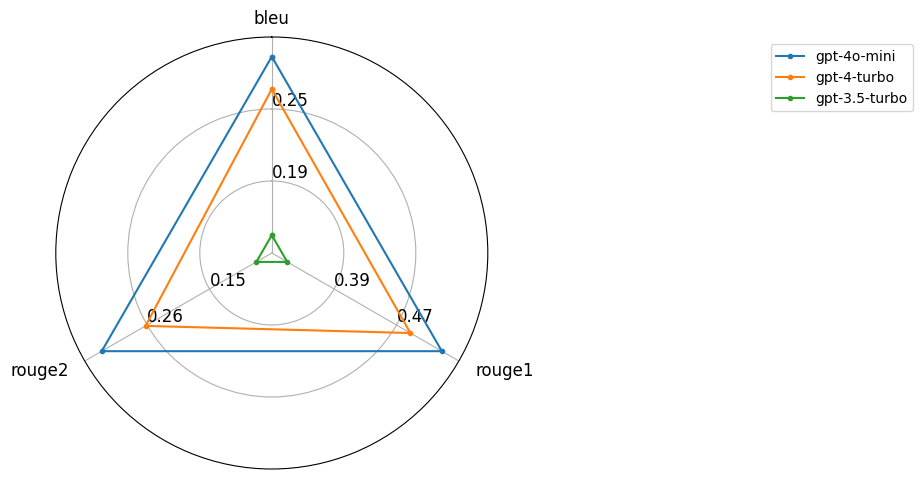

In [35]:
# Create and display visualization
plot = visualize_prompt_comparison(evals, models_test)
plot.show()

The evaluation metrics confirm this ranking, with gpt-4o-mini achieving the closest semantic alignment to the benchmark, followed by gpt-4-turbo, and gpt-3.5-turbo showing the largest deviation. While evaluating language model outputs inherently involves subjective judgment, establishing a high-quality benchmark model and using quantifiable metrics like BLEU and ROUGE scores provides a more objective framework for comparing model performance. This approach transforms an otherwise qualitative assessment into a measurable, data-driven evaluation process.


#### Considerations

While these metrics provide quantifiable measures of performance, they have limitations:

*   **Task-specific nature**:  Metrics like accuracy might not fully capture the nuances of complex tasks, especially those involving subjective human judgment.
*   **Sensitivity to data distribution**: Performance on these metrics can be influenced by the specific dataset used for evaluation, which might not represent real-world data distribution.
*   **Inability to assess reasoning or factual accuracy**: These metrics primarily focus on surface-level matching and might not reveal the underlying reasoning process of the LLM or its ability to generate factually correct information.

In conclusion, selecting the appropriate extrinsic metric depends on the specific NLP task and desired evaluation granularity.  Understanding the limitations of these metrics and considering alternative approaches like human evaluation can provide a more comprehensive assessment of LLM performance in real-world applications.

To address these limitations, alternative approaches like **human evaluation** and **model-based evaluation** are often used, which will be discussed in the following sections.



### Evaluator

#### Model-based Evaluation

#### Human Evaluation

Human assessors can judge aspects like fluency, coherence, and factual accuracy, providing a more comprehensive evaluation. However, human evaluation can be subjective and resource-intensive.


### Leaderboard

Benchmark datasets provide a standardised way to evaluate the performance of LLMs on a variety of downstream tasks. Some popular benchmark datasets include:

* **GLUE (General Language Understanding Evaluation)**: A collection of diverse natural language understanding tasks, such as sentiment analysis, question answering, and textual entailment. GLUE scores provide a holistic view of a model's language understanding capabilities.
* **SuperGLUE**: A successor to GLUE with more challenging tasks designed to push the boundaries of language understanding.
* **BIG-bench**: A collaborative benchmark with a wide range of tasks, encompassing language modeling, reasoning, and common sense.
* **HELM (Holistic Evaluation of Language Models)**: A comprehensive evaluation framework that considers multiple factors, including accuracy, robustness, fairness, and efficiency.
* **FLASK**: A benchmark focused on evaluating the factual accuracy and consistency of language models.

* **Massive Multitask Language Understanding (MMLU):** This benchmark tests a model's knowledge and reasoning abilities across 57 subjects, including STEM, humanities, and social sciences.
* **HumanEval:** This dataset evaluates code generation capabilities by asking a model to write code based on a given description.
* **LiveBench:**  This benchmark attempts to mitigate the problem of data contamination by releasing new questions monthly. 

However, benchmark datasets have limitations.  It can be difficult to prevent data from the benchmarks leaking into the training data, which can inflate the model's performance.  Additionally, some benchmarks may contain incorrect answers or ambiguous questions.  It's also important to remember that benchmark performance does not always translate directly to real-world performance.

## Tools

## References
```{bibliography}
:filter: docname in docnames
```